# Introduction to Time Series Analysis


#### **What is a Time Series ?** 



A time series is a sequence of data points collected or recorded at specific time intervals. These data points are typically ordered chronologically and can represent various phenomena, such as stock prices, temperature readings, or economic indicators. Time series analysis involves studying the patterns, trends, and behaviors within these data to make predictions or gain insights.


#### **Why is it used for ?**


Time series analysis serves as a valuable tool for observing the evolution of a particular asset, security, or economic parameter as it unfolds over time. Additionally, it enables a comparison of the fluctuations in the selected data point with the changes in other variables during the same time frame.

To illustrate, consider a scenario where you wish to scrutinize a time series of a specific stock's daily  prices over a specified duration. In this case, you would compile a chronological list containing all the closing prices of the stock for each day over the past year

### **Step 1 - Collection and Preprocessing of Data**

In [98]:
# Regular libraries for data manipulation
import pprint
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer

# Visualization
from pandas.plotting import lag_plot
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical tools for time series analysis
from scipy import signal
import statsmodels.api as sm
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller, kpss, acf, grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf,month_plot,quarter_plot
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

sns.set_style("whitegrid")
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15)

from pylab import rcParams


#### **What is the source of the data ?**


The OHLCV data of Crude Oil is downloaded from yfiance API. We will be using 'max' setting to get maximum number of data points possible.

In [33]:
# Download Data from yahoo finance API 

data=yf.download(tickers='CL',period='max').reset_index()

[*********************100%%**********************]  1 of 1 completed


In [34]:
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,1973-05-02,0.000000,2.000000,1.966146,2.000000,0.458451,672000
1,1973-05-03,0.000000,2.013021,1.953125,2.005208,0.459645,739200
2,1973-05-04,0.000000,2.028646,1.989583,2.000000,0.458451,1339200
3,1973-05-07,0.000000,2.015625,1.984375,1.989583,0.456063,316800
4,1973-05-08,0.000000,1.989583,1.947917,1.986979,0.455467,619200
...,...,...,...,...,...,...,...
12699,2023-09-08,73.570000,73.800003,73.089996,73.199997,73.199997,3804500
12700,2023-09-11,73.199997,74.129997,73.190002,73.949997,73.949997,3286600
12701,2023-09-12,73.989998,73.989998,72.489998,72.519997,72.519997,3639400
12702,2023-09-13,72.930000,73.220001,72.470001,72.830002,72.830002,3111800


#### **Data Preprocessing**

##### **Checking for missing Values**


Addressing missing data typically necessitates a tailored approach, as there is no one-size-fits-all solution. Various methods can be employed to impute missing values effectively, each with its own unique characteristics:

- Forward Fill and Backward Fill: In this approach, missing values are filled by either taking the preceding data point (forward fill) or the subsequent data point (backward fill) and using it as a replacement.

- Linear Interpolation: Linear interpolation utilizes linear polynomials to estimate missing data points based on the existing data points within the dataset. This method is particularly useful for creating a continuous trend between known values.

- Quadratic Interpolation: Unlike linear interpolation, quadratic interpolation employs non-linear polynomials to estimate missing data points. It is suitable when the relationship between data points is curvilinear.

- Mean of Nearest Neighbors: This method involves calculating the mean of the nearest neighboring data points and using it as a substitute for the missing value. It can be valuable when data points are closely related.

- Mean of Seasonal: When dealing with seasonal data, you can calculate the mean for a specific season or time frame and replace missing values with this seasonal mean. This approach helps maintain seasonality patterns in the data.

By understanding these techniques and their applications, you can choose the most appropriate method to address missing data based on the specific characteristics of your dataset and the nature of the missing values.

In [ ]:
data.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

As we can see that there is no missing values since the data is already obtained preprocessed. In case there was any missing value, we can use any of the above method to impute new value.

#### **Line Plot**

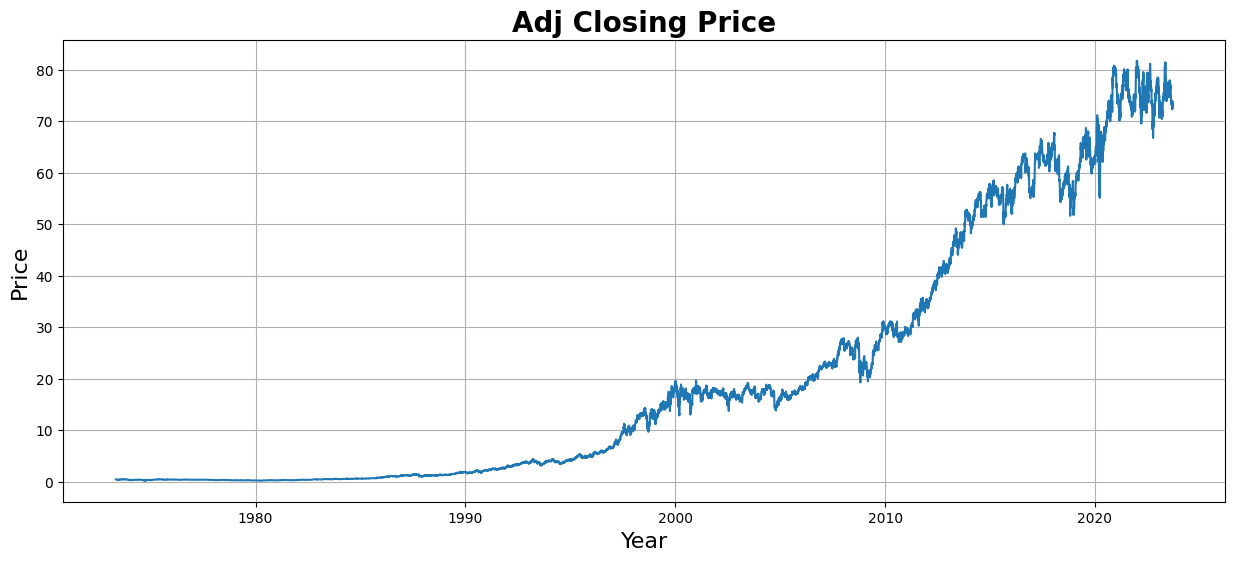

In [35]:
# Line plot
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(x=data['Date'],y=data['Adj Close'] )

# Formatting
ax.set_title('Adj Closing Price', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Year', fontsize = 16)
ax.set_ylabel('Price', fontsize = 16)

# Adjusting tick label sizes for better readability
plt.tick_params(axis='y', which='major', labelsize=10)
plt.tick_params(axis='x', which='major', labelsize=10)
plt.grid(True)

#### **Observations** 

The data seems to lack any noticeable seasonal patterns within each year. Instead, it displays a trend rather than cyclic behavior.



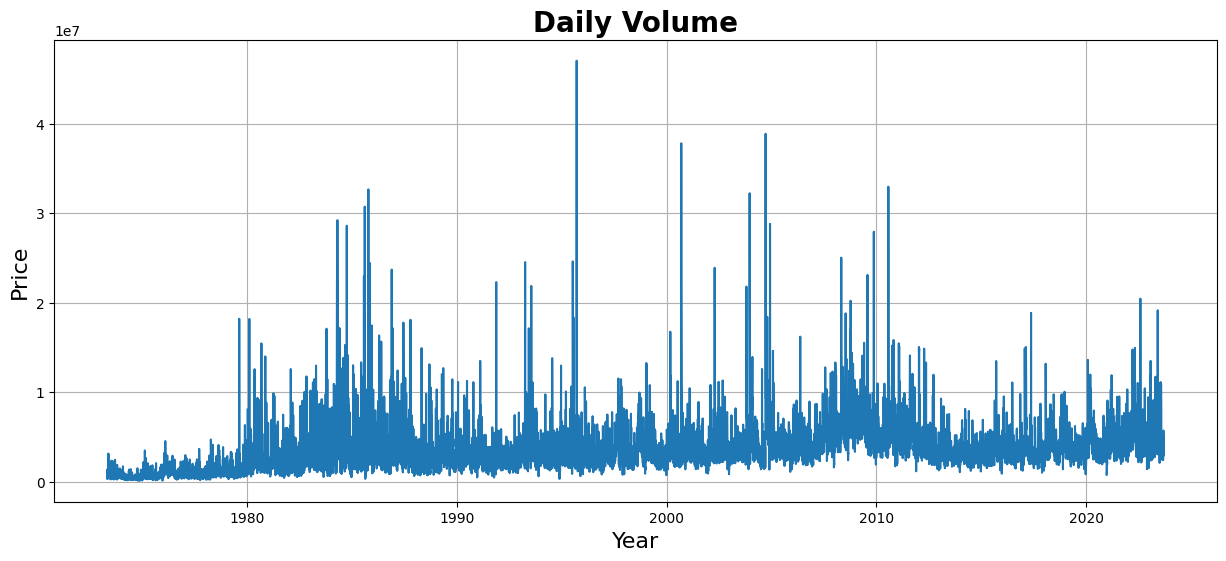

In [36]:
# Plot Daily Volume Lineplot
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(x=data['Date'], y=data['Volume'] )

# Formatting
ax.set_title('Daily Volume', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Year', fontsize = 16)
ax.set_ylabel('Price', fontsize = 16)
plt.tick_params(axis='y', which='major', labelsize=10)
plt.tick_params(axis='x', which='major', labelsize=10)
plt.grid(True)

The graph shows noticeable fluctuations caused by use of the daily timeframe. Switching to the average monthly trading volume, as opposed to the daily data, is anticipated to yield a clearer and more visually appealing representation.






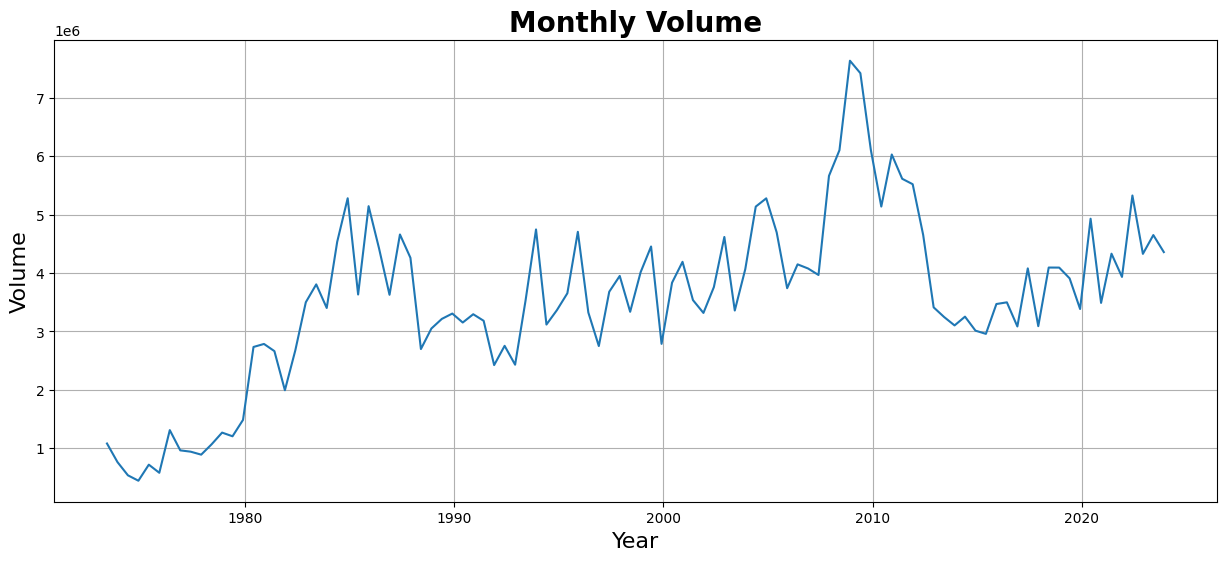

In [46]:
# Create a copy of the 'Date' and 'Volume' columns
month_df = data[['Date','Volume']].copy()

# Set the index to 'Date' and convert it to datetime format
month_df.set_index('Date', inplace=True)
month_df.index = pd.to_datetime(month_df.index)

# Resample the time series to monthly and compute the mean of each month
month_df = month_df.resample('6M').mean()

# Add the 'Date' column back to the DataFrame
month_df['Date'] = month_df.index

# Plot the monthly volume time series
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(x=month_df['Date'], y= month_df['Volume'] )

# Set the title and axes labels
ax.set_title('Monthly Volume', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Year', fontsize = 16 )
ax.set_ylabel('Volume', fontsize = 16)
plt.grid(True)

#### **Observations**

While the graph retains some degree of noise, it has become more understandable. The key lies in selecting the right interval length, striking a balance between clarity and information retention.

A shorter period interval results in a noisier signal but provides richer information.
On the other hand, a longer period interval delivers a more easily understandable signal but at the expense of reduced information.

#### **What is seasonality ?**

Seasonality refers to a recurring pattern or fluctuation in data that tends to follow a regular, predictable cycle over a specific period of time. This pattern is often associated with changes or variations that occur at certain times of the year, such as seasons, months, weeks, or even days. Seasonality is commonly observed in various fields, including economics, finance, weather, and business.

In business and finance, for example, seasonality can manifest as increased sales during the holiday season or higher demand for certain products in specific months. In meteorology, seasonality corresponds to the regular temperature and weather changes that occur with the changing seasons, such as warmer summers and colder winters.

Seasonal patterns are valuable for forecasting and decision-making because they provide insights into when certain events or trends are likely to occur. Analysts often use statistical methods to identify and account for seasonality when analyzing data to make more accurate predictions and informed decisions.

In [47]:
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month

In [50]:
print("List of Year Observations present in data are ", data['Year'].unique())


List of Year Observations present in data are  [1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986
 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000
 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014
 2015 2016 2017 2018 2019 2020 2021 2022 2023]


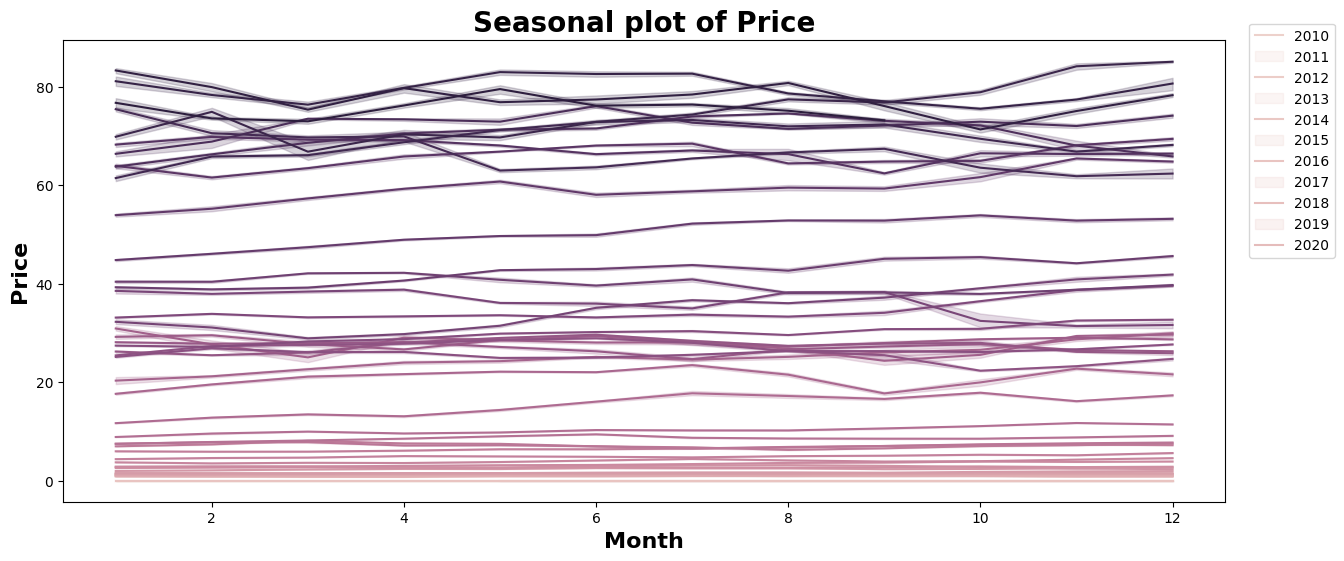

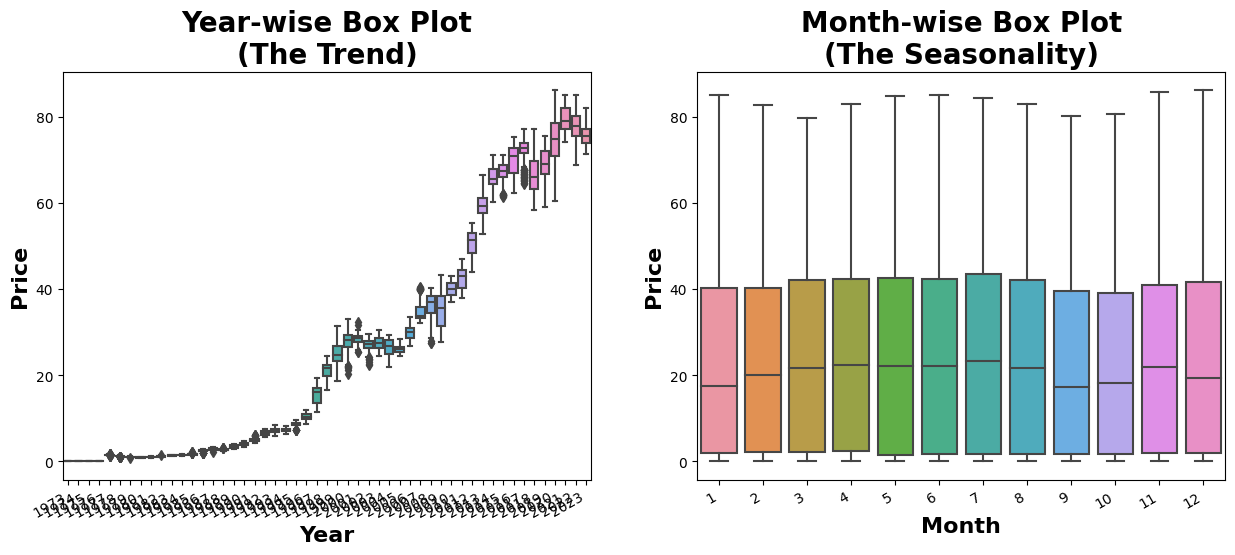

In [52]:
# Set the variable to plot
variable = 'Open'

# Create a figure with one plot
fig, ax = plt.subplots(figsize=(15, 6))

# Plot the seasonal line plot
sns.lineplot(x=data['Month'], y=data[variable], hue = data['Year'])

# Format the plot
ax.set_title('Seasonal plot of Price', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Month', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Price', fontsize = 16, fontdict=dict(weight='bold'))
ax.legend(labels = [str(2010+i) for i in range(11)], bbox_to_anchor=(1.1, 1.05))

# Create a figure with two plots
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot the year-wise box plot
sns.boxplot(x=data['Year'],y= data[variable], ax=ax[0])

# Format the year-wise box plot
ax[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax[0].set_xlabel('Year', fontsize = 16, fontdict=dict(weight='bold'))
ax[0].set_ylabel('Price', fontsize = 16, fontdict=dict(weight='bold'))

# Plot the month-wise box plot
sns.boxplot(x=data['Month'], y=data[variable], ax=ax[1])

# Format the month-wise box plot
ax[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax[1].set_xlabel('Month', fontsize = 16, fontdict=dict(weight='bold'))
ax[1].set_ylabel('Price', fontsize = 16, fontdict=dict(weight='bold'))

# Rotate the x-axis labels for better readability
fig.autofmt_xdate()

Overall, these plots enable you to:

- Assess the presence of seasonal patterns, if any
- Determine the years during which the pattern shifts
- Identify significant increases or decreases

In the trend and seasonality boxplot:

- Instantly examine trends and seasonality
- Identify outliers

In [75]:
data

,Date,Open,High,Low,Close,Adj Close,Volume,Year,Month
0,1973-05-02,0.000000,2.000000,1.966146,2.000000,0.458451,672000,1973,5
1,1973-05-03,0.000000,2.013021,1.953125,2.005208,0.459645,739200,1973,5
2,1973-05-04,0.000000,2.028646,1.989583,2.000000,0.458451,1339200,1973,5
3,1973-05-07,0.000000,2.015625,1.984375,1.989583,0.456063,316800,1973,5
4,1973-05-08,0.000000,1.989583,1.947917,1.986979,0.455467,619200,1973,5
...,...,...,...,...,...,...,...,...,...
12699,2023-09-08,73.570000,73.800003,73.089996,73.199997,73.199997,3804500,2023,9
12700,2023-09-11,73.199997,74.129997,73.190002,73.949997,73.949997,3286600,2023,9
12701,2023-09-12,73.989998,73.989998,72.489998,72.519997,72.519997,3639400,2023,9
12702,2023-09-13,72.930000,73.220001,72.470001,72.830002,72.830002,3111800,2023,9


Text(0, 0.5, 'Close')

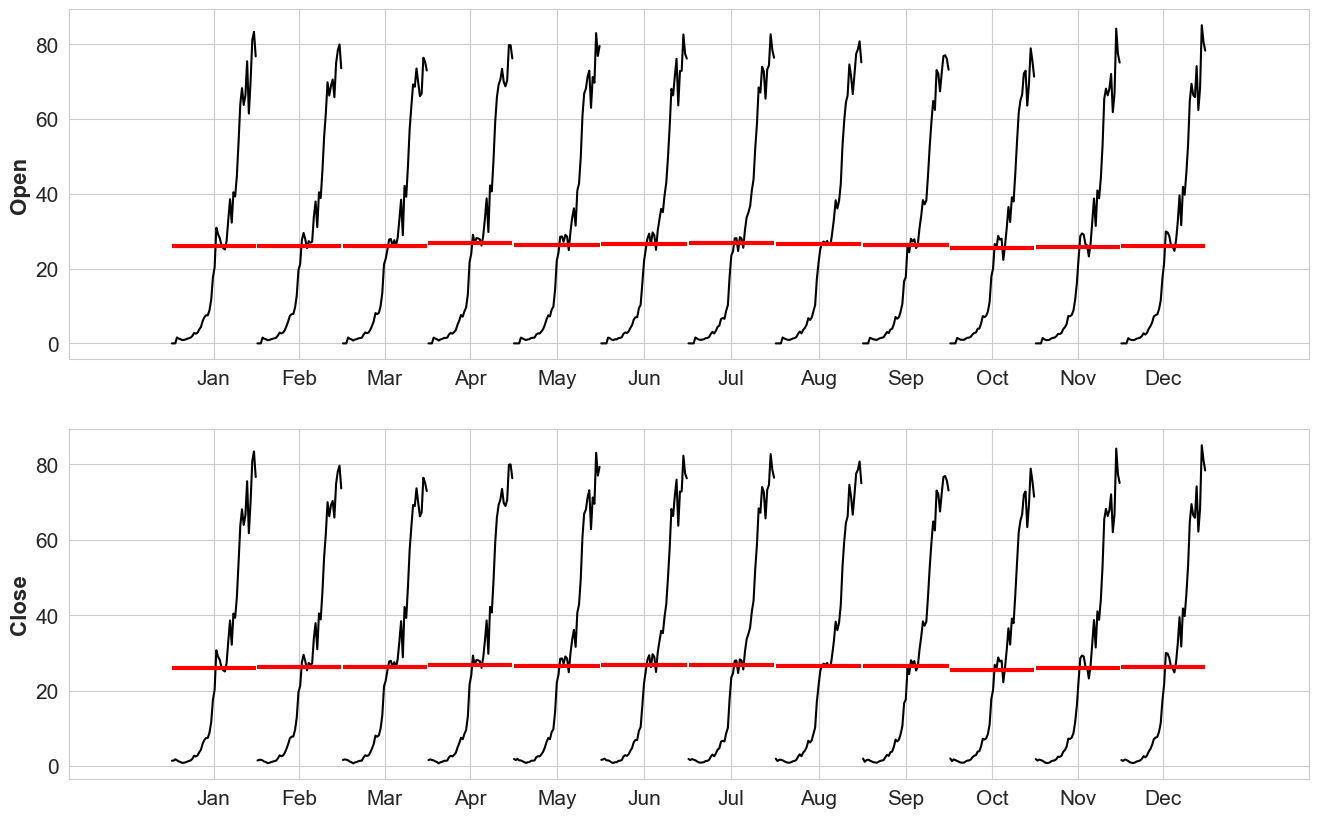

In [77]:
# Aggregating the Time Series to a monthly scaled index
y = data[['Date','Open','Close']].copy()
y.set_index('Date', inplace=True)
y.index = pd.to_datetime(y.index)
y = y.resample('1M').mean()

# Create the seasonal subseries plots
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 10))

month_plot(y['Open'], ax=ax[0]);
ax[0].set_ylabel('Open', fontsize = 16, fontdict=dict(weight='bold'))

month_plot(y['Close'], ax=ax[1]);
ax[1].set_ylabel('Close', fontsize = 16, fontdict=dict(weight='bold'))

### Time Series Components

If we assume an additive decomposition, then we can write:

$
y_t = S_t + T_t + R_t
$

where $y_t$ is the data, $S_t$ is the seasonal component, $T_t$ is the trend-cycle component, and $R_t$ is the residual component, all at period $t$. 

Also, for a multiplicative decomposition, we have:

$
y_t = S_t \cdot T_t \cdot R_t
$

The additive decomposition is the most appropriate if the magnitude of the seasonal fluctuations, or the variation around the trend-cycle, does not vary with the level of the time series. When the variation in the seasonal pattern, or the variation around the trend-cycle, appears to be proportional to the level of the time series, then a multiplicative decomposition is more appropriate. Multiplicative decompositions are common with economic time series.


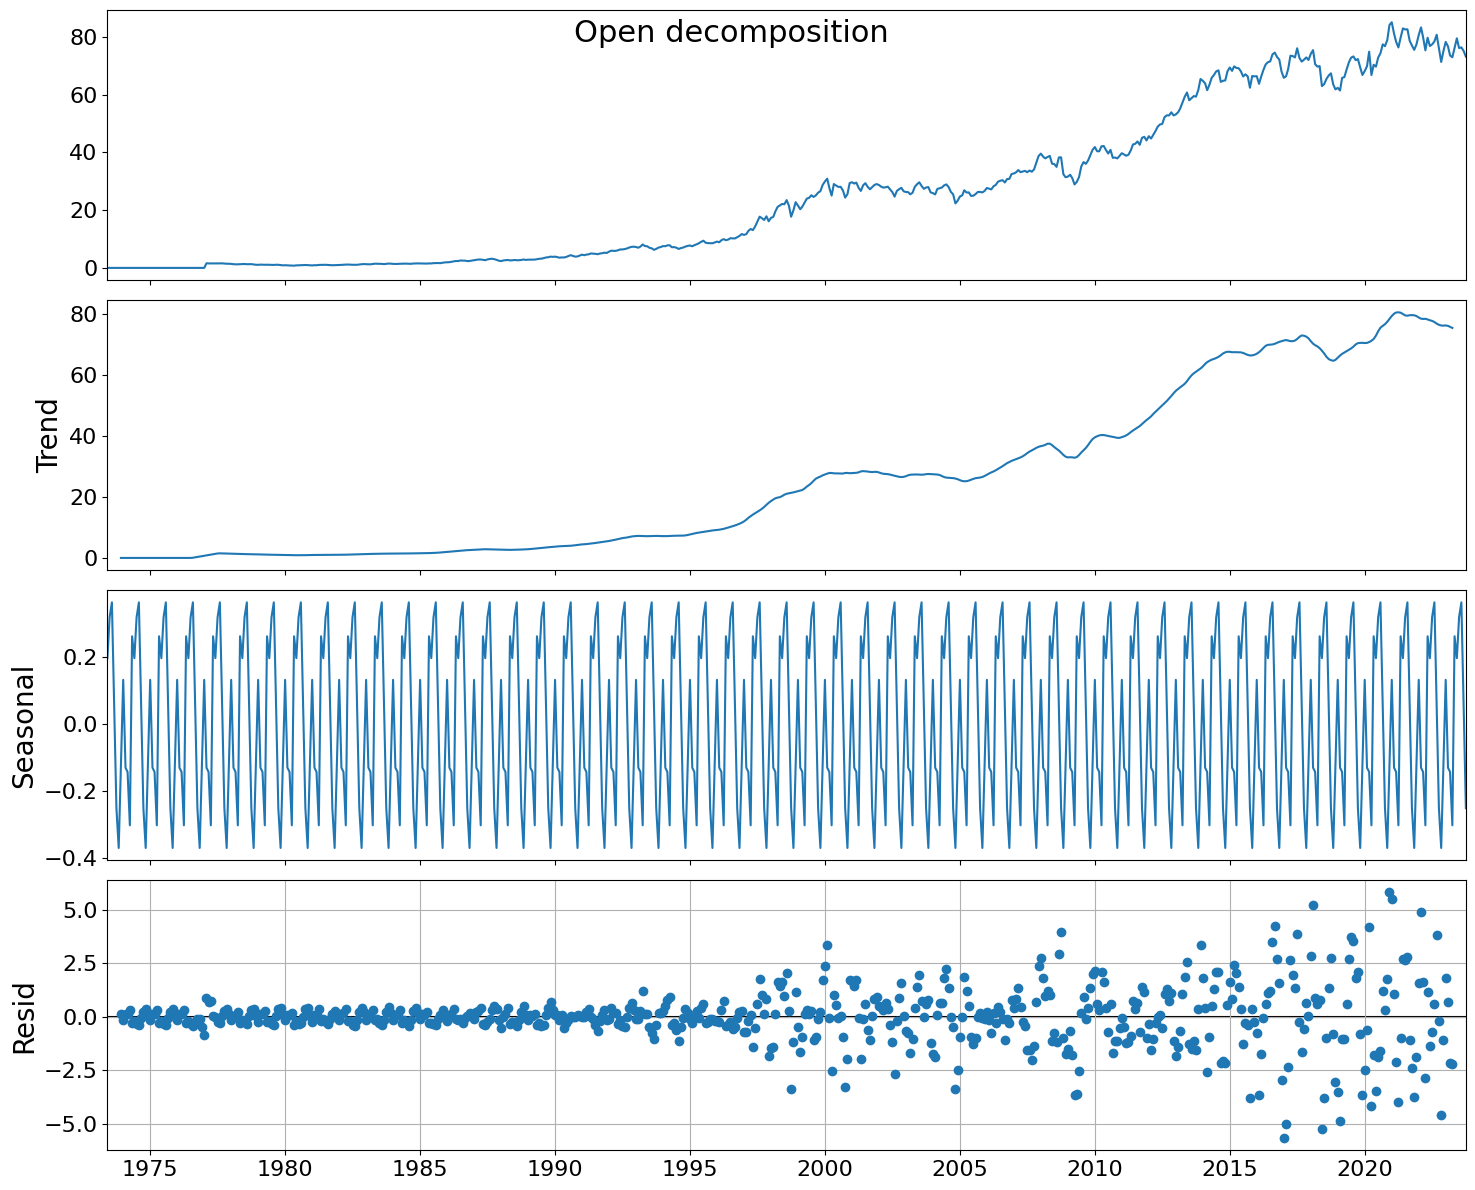

In [71]:
# Aggregating the Time Series to a monthly scaled index
y = data[['Date', 'Open']].copy()
y.set_index('Date', inplace=True)
y.index = pd.to_datetime(y.index)
y = y.resample('1M').mean()

# Setting rcparams for plot size and font size
plt.rcParams['figure.figsize'] = 15, 12
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 16

# Using statistical tools of statsmodel library to perform seasonal decomposition
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
# Plotting the decomposition
decomp = decomposition.plot()
decomp.suptitle('Open decomposition', fontsize=22)
plt.grid(True)

### Stationarity 

#### Defining Stationariy 

Stationarity, in the context of time series data, refers to a fundamental property where the statistical characteristics of a dataset remain relatively constant over time. In other words, a stationary time series exhibits consistent statistical properties such as mean, variance, and autocorrelation structure, regardless of when the data is observed.

There are typically three key aspects to consider when defining stationarity:

Constant Mean: A stationary time series should have a mean (average) that remains constant or doesn't show any significant trend across different time periods. This means that the overall level of the data doesn't change over time.

Constant Variance: The variance (spread or dispersion) of the data points should also remain constant over time. In other words, the data should exhibit consistent volatility throughout the time series.

Constant Autocorrelation: Autocorrelation measures the relationship between a data point and its past observations. In a stationary time series, the autocorrelation structure should remain stable across different time intervals, indicating that patterns repeat consistently.

Achieving stationarity is crucial in time series analysis because many statistical models and techniques assume stationarity to make accurate predictions and inferences. If a time series is non-stationary, meaning it exhibits trends or seasonality, it may need to be transformed or differenced to make it stationary before applying certain analytical methods.

#### What is the purpose of stationarity?



Most statistical forecasting techniques are designed to work effectively with time series data that exhibit stationarity. The first step in the forecasting process often entails converting a non-stationary time series into a stationary one. Forecasting a stationary series is generally simpler and provides more dependable results.

In the context of linear regression, optimal performance is achieved when the predictors (X variables) are not strongly correlated with each other. The process of making the time series stationary addresses this challenge by eliminating persistent autocorrelation, thereby making the predictors (lags of the series) in forecasting models nearly independent

#### How can a time series be made stationary?



"There are various methods to achieve this:

- Differencing the series one or more times, which involves subtracting the current value from the next value.
- Taking the natural logarithm of the series to stabilize its variance.
- Applying the nth root transformation to the series.
- Combining any of the methods mentioned above.

To assess the stationarity of a time series, you can:

- Examine the time plot.
- Divide the series into two segments and calculate descriptive statistics for each. If these statistics significantly differ, it indicates non-stationarity.
- Perform statistical tests known as Unit Root Tests, including the Augmented Dickey Fuller test (ADF Test), the Kwiatkowski-Phillips-Schmidt-Shin test (KPSS test, which assesses trend stationarity), and the Philips Perron test (PP Test).

The ADF test is the most commonly used among these. It tests the null hypothesis that the time series has a unit root (or follows a random walk with drift), indicating non-stationarity. If the p-value obtained from the ADF test is less than the chosen significance level (often set at 0.05), the null hypothesis is rejected, and the series is considered stationary."

In [79]:
def adf_test(series, title=''):
    """
    Perform the Augmented Dickey-Fuller test on a time series.

    Parameters:
        series (pd.Series): The time series to be tested.
        title (str): Optional title to be displayed in the results.

    Returns:
        None

    Prints an ADF report that includes the following statistics:
    - ADF test statistic
    - p-value
    - Number of lags used
    - Number of observations
    - Critical values at 1%, 5%, and 10% significance levels

    Also prints a conclusion about the stationarity of the series based on the p-value.

    Example:
        >>> adf_test(y['Open'], title='Open Prices')
    """
    
    print('Augmented Dickey-Fuller Test: {}'.format(title))
    
    # Perform Augmented Dickey-Fuller test
    result = adfuller(series.dropna(),autolag='AIC') 
    
    # Create a Series object with the test statistics and critical values
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)
    
    # Add the critical values to the Series object
    for key,val in result[4].items():
        out['critical value ({})'.format(key)]=val
        
    # Print the ADF report
    print(out.to_string())          
    
    # Check for stationarity based on the p-value
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [80]:
# Aggregating the Time Series to a monthly scaled index
y = data[['Date','Open']].copy()
y.set_index('Date', inplace=True)
y.index = pd.to_datetime(y.index)
y = y.resample('1M').mean()

# Perform the ADF test on the Open prices
adf_test(y['Open'],title='')

Augmented Dickey-Fuller Test: 
ADF test statistic        0.458930
p-value                   0.983570
# lags used              18.000000
# observations          586.000000
critical value (1%)      -3.441558
critical value (5%)      -2.866485
critical value (10%)     -2.569403
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


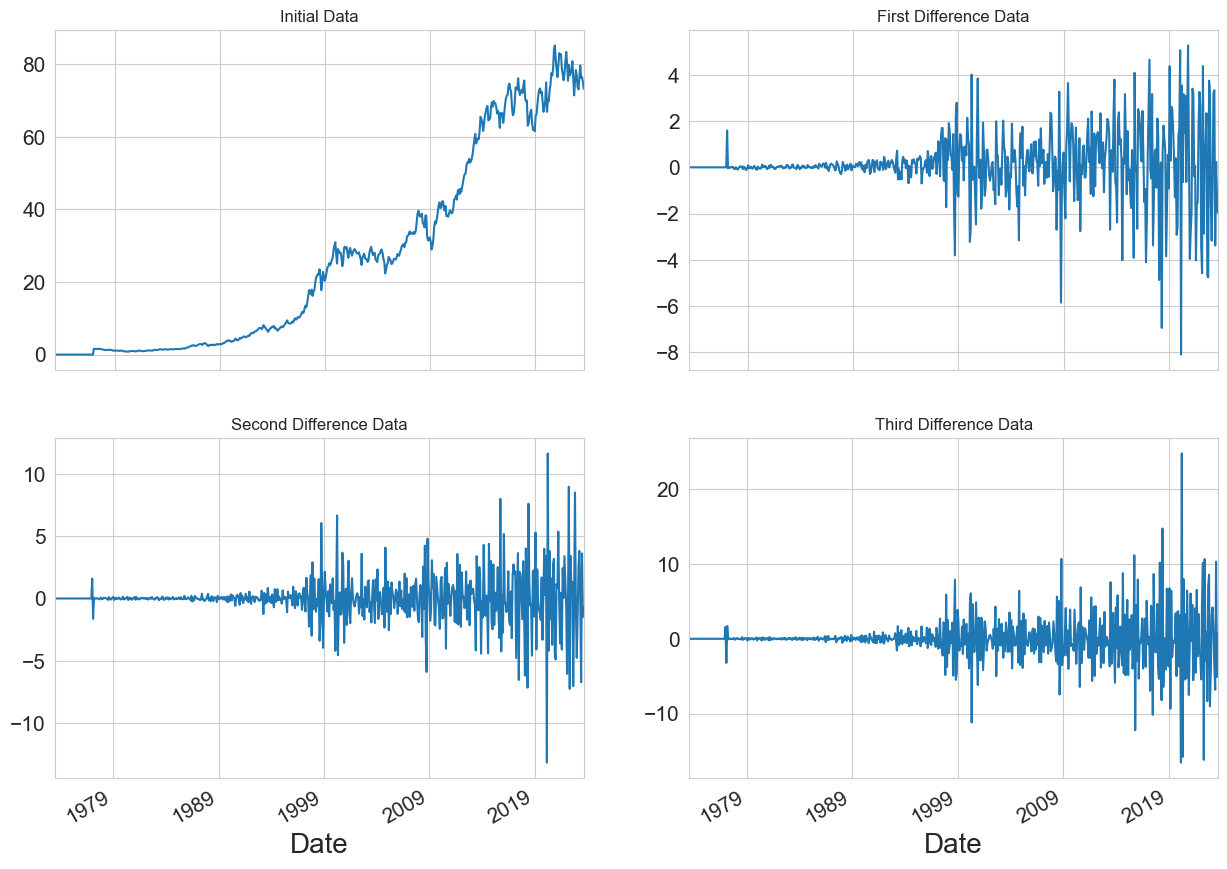

In [81]:
# Create a 2x2 grid of subplots
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 11))

# Apply differencing to the 'Open' column and add it to the dataframe
y['OpenDiff1'] = diff(y['Open'], k_diff=1)
y['OpenDiff2'] = diff(y['Open'], k_diff=2)
y['OpenDiff3'] = diff(y['Open'], k_diff=3)

# Plot the initial 'Open' data on the first subplot
y['Open'].plot(title="Initial Data", ax=ax[0][0]).autoscale(axis='x', tight=True);

# Plot the first difference data on the second subplot
y['OpenDiff1'].plot(title="First Difference Data", ax=ax[0][1]).autoscale(axis='x', tight=True);

# Plot the second difference data on the third subplot
y['OpenDiff2'].plot(title="Second Difference Data", ax=ax[1][0]).autoscale(axis='x', tight=True);

# Plot the third difference data on the fourth subplot
y['OpenDiff3'].plot(title="Third Difference Data", ax=ax[1][1]).autoscale(axis='x', tight=True);

# Rotate the x-axis labels to make them easier to read
fig.autofmt_xdate()

#### Differentiating Correlation, Autocorrelation, and Partial Autocorrelation



**Correlation** measures the strength of a linear connection between two variables.

**Autocorrelation** examines the linear association between a time series and its past values, like the relationship between $y_t$ and $y_t−1$. A significant autocorrelation suggests that earlier data points (lags) may help in predicting the present one.

**Partial autocorrelations** evaluate the linear reliance of one variable while considering the influence of other variable(s) that affect both of them. In simpler terms, the partial autocorrelation at lag $k$ signifies the autocorrelation between $y_t$ and $y_t+y_t+k$, excluding the effects of lags 1 through $k−1$.

Typically, we visualize the connection between the previous day's/month's residuals and the current day's actual values. Generally, we expect the partial autocorrelation to decrease rapidly.

[1.         0.99970334 0.99941677 0.99913577 0.99886769 0.99860638
 0.99834844 0.99808406 0.99781814 0.99754437 0.9972663  0.99699457
 0.99672894 0.99645986 0.99619064 0.99592767 0.99567137 0.99541701
 0.99516385 0.99490782 0.99465228 0.99440118 0.9941487  0.99388546
 0.99362474 0.99336294 0.9931088  0.99285287 0.9925928  0.99233613
 0.99207887 0.9918259  0.99157373 0.99132448 0.99108598 0.99083518
 0.99058907 0.99033764 0.99008796 0.98983435 0.98959208 0.98934871
 0.98911011 0.98887551 0.98864591 0.98841734 0.98818932 0.98796599
 0.98774674 0.98751805 0.9872896  0.98706257 0.98684313 0.98662053
 0.98640169 0.98618575 0.98596656 0.98574477 0.98550764 0.98526172
 0.98502392]


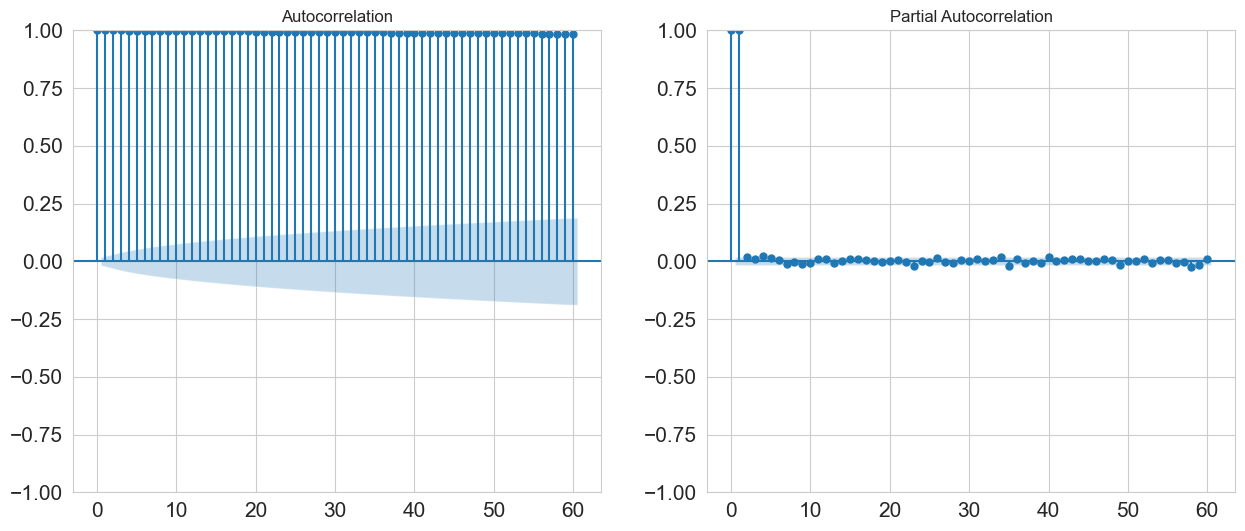

In [83]:
# Creating a figure with two subplots
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(15, 6))

# Calculating autocorrelation function (ACF) with 60 lags for Open prices
autocorr = acf(data['Open'], nlags=60, fft=False)
print(autocorr)

# Plotting the ACF with 60 lags on the first subplot
plot_acf(data['Open'].tolist(), lags=60, ax=ax[0], fft=False);

# Plotting the partial autocorrelation function (PACF) with 60 lags on the second subplot
plot_pacf(data['Open'].tolist(), lags=60, ax=ax[1]);

- In autocorrelation, the y-axis represents the correlation between a data point and its lagged counterpart, while the x-axis indicates the lag. The correlation at zero-lag is 1 since it perfectly correlates with itself.

- The autocorrelation plot reveals that the majority of spikes do not reach statistical significance. This suggests that the returns do not exhibit strong correlations, as demonstrated here.

### Lag Scatter Plot


**Definition**

A scatter plot serves as a valuable tool for exploring the connection between each data point and its lag. It presents the observation at time 't' on the x-axis and the observation at lag 1 (t-1) on the y-axis.

When the data points form clusters along a diagonal line extending from the bottom-left to the top-right of the plot, it signifies a positive correlation relationship. Conversely, if the points cluster along a diagonal line extending from the top-left to the bottom-right, it indicates a negative correlation relationship. Both types of relationships are significant and can be modeled.

The strength of the relationship is determined by how close the points are to the diagonal line. A tighter clustering indicates a stronger relationship, while greater dispersion from the line suggests a weaker one. If the points are concentrated in the center or scattered widely across the plot, it suggests a weak or nonexistent relationship.

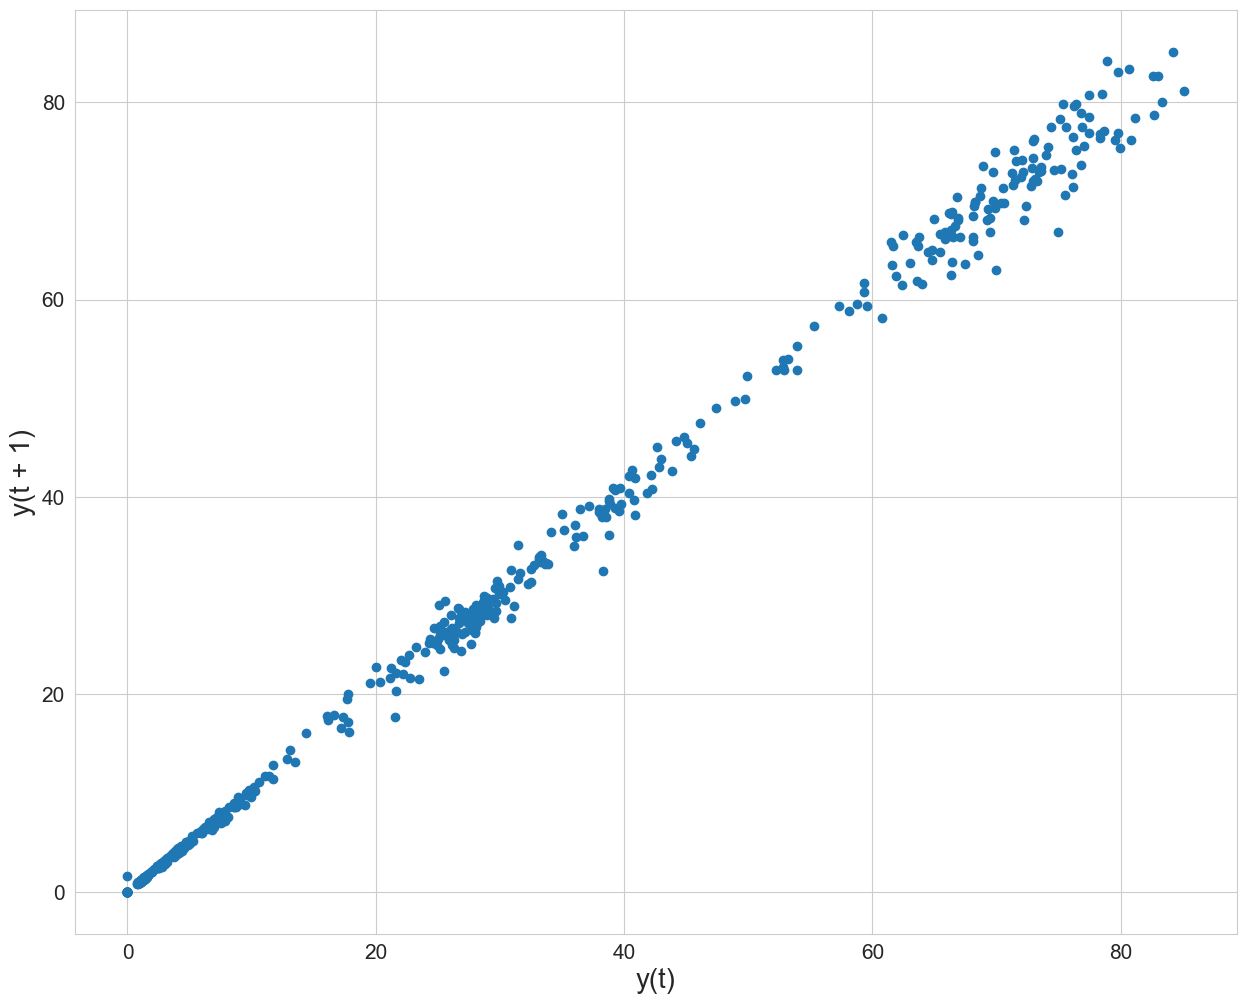

In [84]:
lag_plot(y['Open']);


Here there is a **positive correlation** relationship.


**Defining Moving Averages**


Moving average is the estimation of the trend-cycle at time t, and is obtained by averaging the values of the time series within k periods of t. Observations that are nearby in time are also likely to be close in value. Therefore, the average eliminates some of the randomness in the data, leaving a smooth trend-cycle component.

It can be written as

$
\hat{T}_t = \frac{1}{m} \sum_{j=-k}^k y_{t+j}
$
 
where  $m=2k+1$
 . That is, the estimate of the trend-cycle at time  $t$
  is obtained by averaging values of the time series within k periods of  $t$
 .

- Smaller windows will lead to more noise.
- It will always lag by the size of the window.
- It will never reach the full peak or valley of the data due to the averaging.
- It does not really inform you about possible future behavior, all it really does is describe trends in your data.
- Extreme historical values can skew MA significantly.

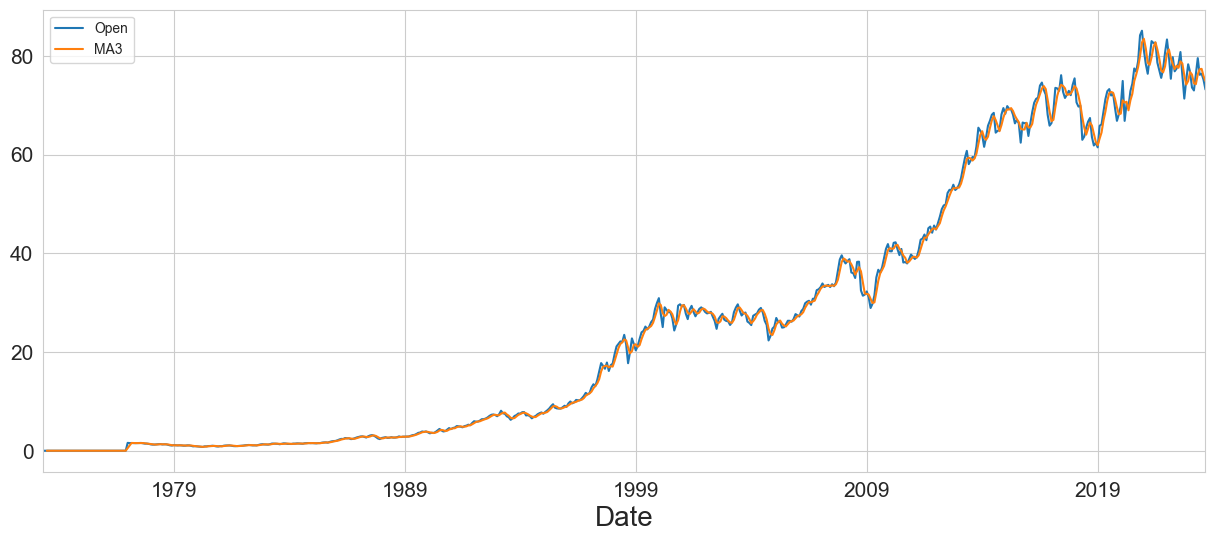

In [87]:
# Aggregating the Time Series to a monthly scaled index
y = data[['Date','Open']].copy()
y.set_index('Date', inplace=True)
y.index = pd.to_datetime(y.index)
y = y.resample('1M').mean()

# Compute rolling mean with window size of 3
y['MA3'] = y.rolling(window=3).mean() 

# Plot the resulting time series
y.plot(figsize=(15,6))
plt.show();

Exponential smoothing assigns **exponentially decreasing weights** for **newest** to **oldest** observations. In other words, the older the data, the less priority (“weight”) the data is given. Newer data is seen as more relevant and is assigned more weight. Smoothing parameters usually denoted by  $ α
(0<α≤1)$ determine the weights for observations. Exponential smoothing is usually used to make **short term forecasts**, as longer term forecasts using this technique **can be quite unreliable**.

<Axes: xlabel='Date'>

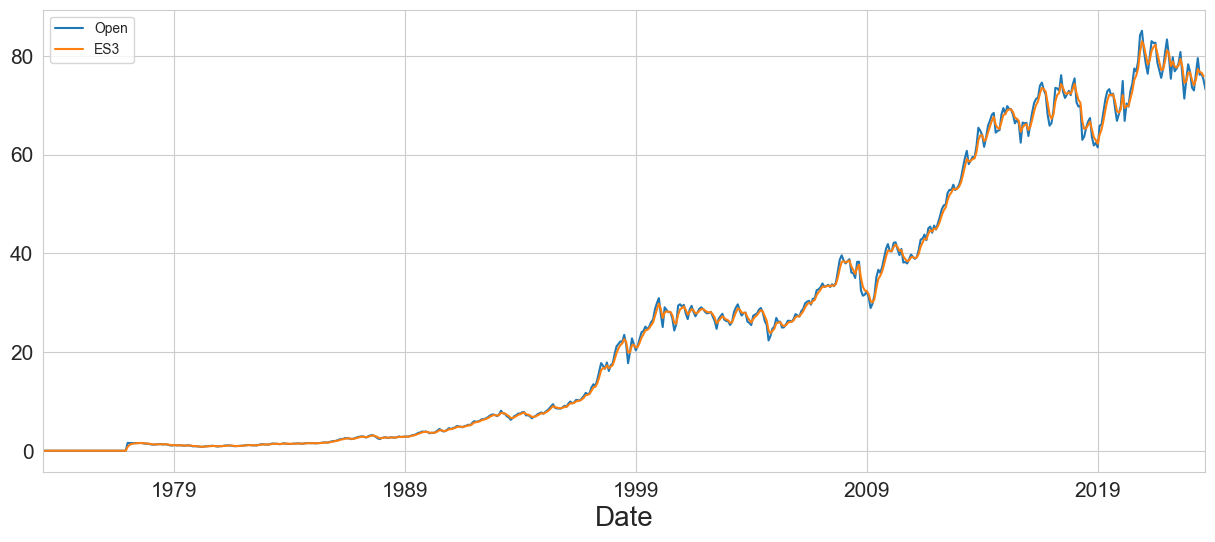

In [88]:
# Setting parameters value
span = 3
# Weights of observations
alpha = 2/(span+1)

# Plot Simple exponential smoothing
# Fit the model using SimpleExpSmoothing and set smoothing level alpha to alpha
# Shift the fitted values by one time step to plot them against the original data
y['ES3'] = SimpleExpSmoothing(y['Open']).fit(smoothing_level = alpha, optimized = False).fittedvalues.shift(-1)

# Plot the original 'Open' values and the Simple exponential smoothing fitted values
y[['Open','ES3']].plot(figsize=(15,6))

#### Simple, Double, Triple exponential Smoothing ?



**Simple Exponential Smoothing** employs a **weighted moving average with exponentially decreasing weights.**

**Double Exponential Smoothing** adds a second smoothing factor  $β( 0<β≤1)$ that addresses trends in the data. The benefit here is that the model can anticipate future increases or decreases where the level model would only work from recent calculations. We can also address different types of change (growth/decay) in the trend. If a time series displays a straight-line sloped trend, you would use an additive adjustment. If the time series displays an exponential (curved) trend, you would use a multiplicative adjustment.

**Triple Exponential Smoothing** (also called the Multiplicative Holt-Winters), the method is usually more reliable for parabolic trends or data that shows trends and seasonality.

<Axes: xlabel='Date'>

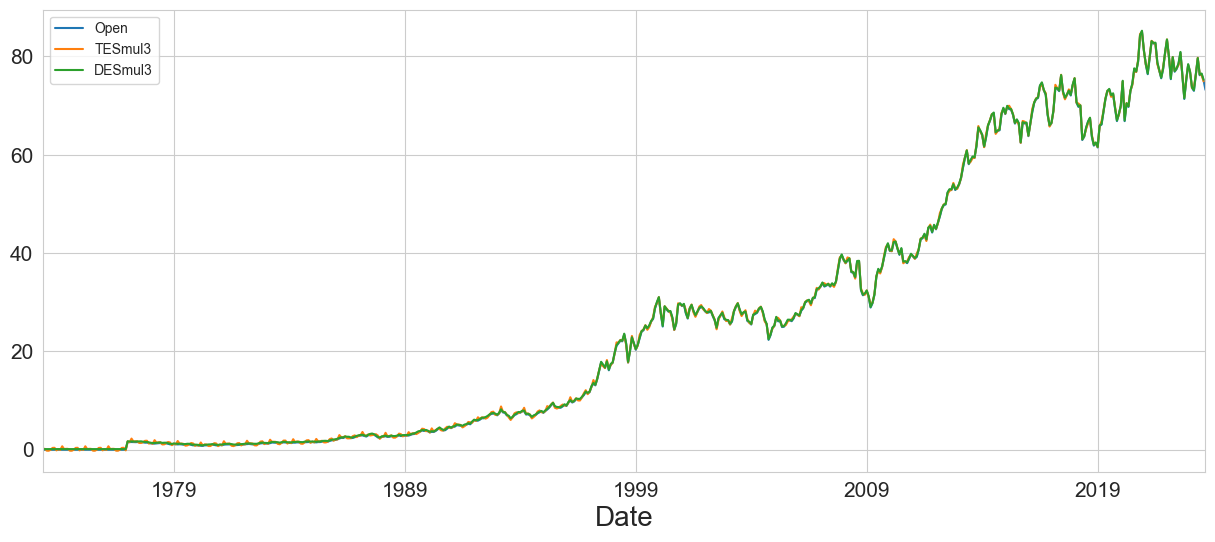

In [89]:
# Plot Double and Triple exponential smoothing

# Double Exponential Smoothing (Holt's Linear Method)
y['DESmul3'] = ExponentialSmoothing(y['Open'], trend='add').fit().fittedvalues.shift(-1)

# Triple Exponential Smoothing (Holt-Winters' Method)
y['TESmul3'] = ExponentialSmoothing(y['Open'], trend='add', seasonal='add', seasonal_periods=12).fit().fittedvalues.shift(-1)

# Plot the original time series and the two smoothed versions
y[['Open', 'TESmul3', 'DESmul3']].plot(figsize=(15, 6))

#### Forecasting with Auto ARIMA

Now we are going to create an ARIMA model and will train it with the closing price of the stock on the train data. So let us split the data into training and test set and visualize it.



In [90]:
# Reverse index so the dataframe is from oldest to newest values
data = data.reindex(index=data.index[::-1])

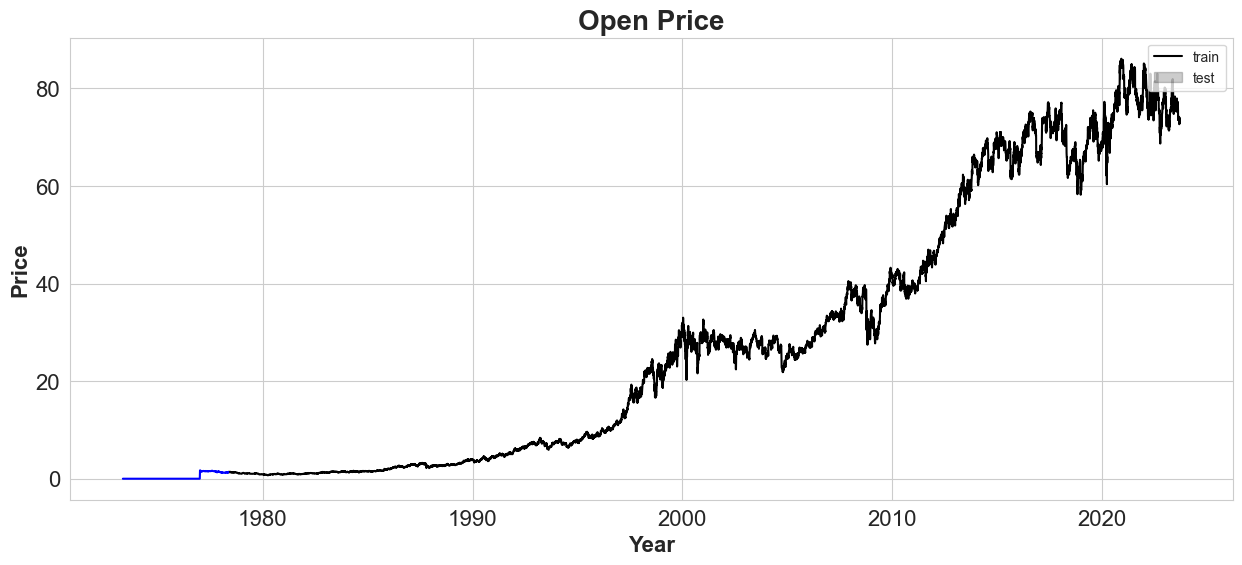

In [92]:
# Split data into train and validation set 90/10
data_train, data_val = data[:int(len(data)*0.9)], data[int(len(data)*0.9):]

# Set the index to the 'Date' column for both train and validation sets
data_val = data_val.set_index('Date', drop=False)
data_train = data_train.set_index('Date', drop=False)

# Plot the train and validation sets as separate lines
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(x=data_train['Date'], y=data_train['Open'], color = 'black')
sns.lineplot(x=data_val['Date'], y=data_val['Open'], color = 'blue')

# Formatting
ax.set_title('Open Price', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Year', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Price', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)
plt.legend(loc='upper right' ,labels = ('train', 'test'))

In [129]:
len(data_val)

1271

Now, it's time to select the parameters p, q, and d for the ARIMA model. While we previously determined these values by examining the ACF and PACF plots, we can now use Auto ARIMA to find the best parameters without the need to plot ACF and PACF graphs.

**Auto ARIMA** is an automated tool designed to identify the optimal order for an ARIMA model. The 'auto_arima' function aims to discover the most suitable parameters for an ARIMA model and provides a fitted ARIMA model as output. This function is based on the well-established R function 'forecast::auto.arima'.

The 'auto_arima' function operates by conducting differencing tests, such as the Kwiatkowski-Phillips-Schmidt-Shin, Augmented Dickey-Fuller, or Phillips-Perron tests, to determine the order of differencing, denoted as 'd'. It then proceeds to fit models within specified ranges for 'p' and 'q', where 'start_p', 'max_p', 'start_q', and 'max_q' define these ranges. Additionally, if the seasonal option is enabled, 'auto_arima' also endeavors to identify the optimal 'P' and 'Q' hyperparameters. To achieve this, it performs the Canova-Hansen test to determine the appropriate order of seasonal differencing, 'D'.

In [94]:
%%time
model_autoARIMA = auto_arima(data['Open'])

""", 
                             start_p = 0, 
                             start_q = 0,
                             test = 'adf', # use adftest to find optimal 'd'
                             max_p = 3,
                             max_q = 3, # maximum p and q
                             m = 7, # frequency of series
                             seasonal = False,
                             start_P = 0, 
                             D = 0, 
                             trace = True,
                             error_action = 'ignore',  
                             stepwise = True
"""

print(model_autoARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                12704
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -7736.789
Date:                Fri, 15 Sep 2023   AIC                          15485.578
Time:                        09:42:23   BIC                          15530.276
Sample:                             0   HQIC                         15500.530
                              - 12704                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0019      0.001     -1.594      0.111      -0.004       0.000
ar.L1          1.3240      0.060     21.903      0.000       1.206       1.442
ar.L2         -0.6488      0.040    -16.112      0.0

In the comment, you can see the parameters used based on the documentation and the Time Series at hand. However, I wasn't entirely satisfied with the prediction (The best model was an ARMA(2,1), which was decreasing, whereas the trend has been increasing for the past 10 years). To be honest, I encountered some difficulties in fine-tuning this model. I believe this resource could be helpful. If you have any suggestions on the proper way to approach this, please feel free to leave a comment. I would greatly appreciate it.



Next, create an ARIMA model with provided optimal parameters p, d and q.



In [110]:
model = ARIMA(data['Open'], order = (2, 1, 2))
fitted = model.fit()
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                   Open   No. Observations:                12704
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -7738.097
Date:                Fri, 15 Sep 2023   AIC                          15486.193
Time:                        10:03:08   BIC                          15523.441
Sample:                             0   HQIC                         15498.653
                              - 12704                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3279      0.060     22.096      0.000       1.210       1.446
ar.L2         -0.6515      0.040    -16.244      0.000      -0.730      -0.573
ma.L1         -1.3681      0.061    -22.403      0.0

Now let's start forecast the stock prices on the test dataset with 95% confidence level.



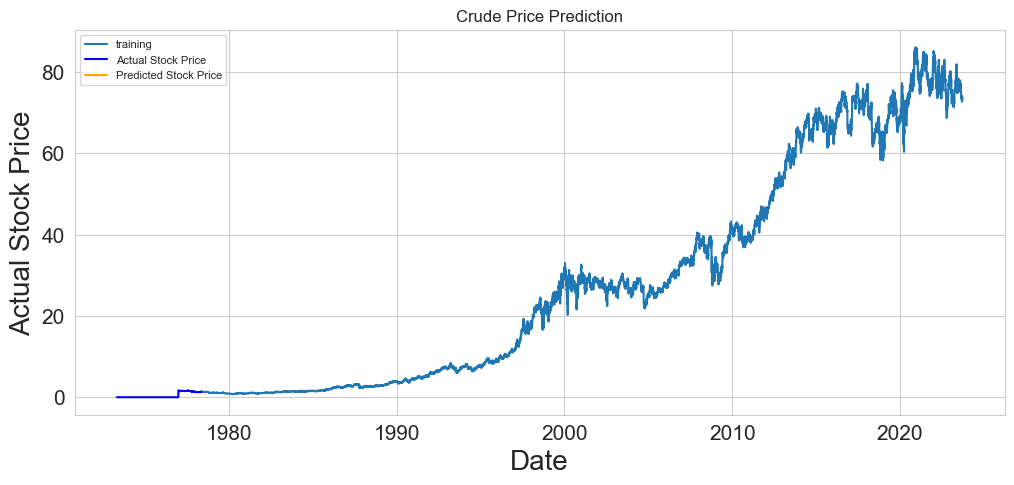

In [133]:
# Forecast 260 next observations 
fc = fitted.forecast(steps=1271,alpha=0.05,color='ornage')  # 95% confidence
fc_series = pd.Series(fc, index=data_val.index)


# Plotting the predicted and actual stock prices
plt.figure(figsize=(12,5), dpi=100)
plt.plot(data_train['Open'], label ='training')
plt.plot(data_val['Open'], color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')

plt.title('Crude Price Prediction')
plt.xlabel('Date')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

As you can observe, our model performed quite well. Additionally, let's evaluate the commonly used accuracy metrics to assess the quality of our forecast results



In [134]:
# Report performances
mse = mean_squared_error(data_val['Open'], fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(data_val['Open'], fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(data_val['Open'], fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - data_val['Open'])/np.abs(data_val['Open']))
print('MAPE: '+str(mape))

MSE: 0.5747548481149352
MAE: 0.3922355060592399
RMSE: 0.7581258788057134
MAPE: nan


A MAPE (Mean Absolute Percentage Error) of approximately 11% suggests that the model is about 89% accurate in predicting the test set observations. Overall, the value is close. However, the model was unable to predict the higher than normal growth for the past year, nor could it foresee the COVID-19 crisis, which resulted in a decrease in Open prices.

